In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 30, 10

In [3]:
all_patients = pd.DataFrame(columns=['time', 'L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'total_force_L', 'total_force_R', 'age', 'gender', 'speed','height', 'weight', 'label', 'patient_id' ])

In [4]:
demograph = pd.read_csv("demographics.txt", sep="\t")
demograph["Weight"] = demograph.Weight.fillna(72) 
demograph["Gender"] = demograph["Gender"] - 1

In [5]:
demograph.head()

,ID,Study,Group,Subjnum,Gender,Age,Height,Weight,HoehnYahr,UPDRS,...,Speed_05,Speed_06,Speed_07,Speed_10,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
0,GaPt03,Ga,1,3,1,82,1.45,50.0,3.0,20.0,...,NaN,NaN,NaN,0.778,NaN,NaN,NaN,NaN,NaN,NaN
1,GaPt04,Ga,1,4,0,68,1.71,72.0,2.5,25.0,...,NaN,NaN,NaN,0.818,NaN,NaN,NaN,NaN,NaN,NaN
2,GaPt05,Ga,1,5,1,82,1.53,51.0,2.5,24.0,...,NaN,NaN,NaN,0.614,NaN,NaN,NaN,NaN,NaN,NaN
3,GaPt06,Ga,1,6,0,72,1.70,82.0,2.0,16.0,...,NaN,NaN,NaN,0.937,NaN,NaN,NaN,NaN,NaN,NaN
4,GaPt07,Ga,1,7,1,53,1.67,54.0,3.0,44.0,...,NaN,NaN,NaN,0.579,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
import os

directory = r'D:\Study\Signals\gait-in-parkinsons-disease-1.0.0\gait-in-parkinsons-disease-1.0.0'
curr_id = 0 
for filename in os.listdir(directory):
    if filename.endswith("01.txt"):
        demo = demograph[demograph["ID"] == filename.split(".")[0].split("_")[0]]
        test = pd.read_csv(filename, sep="\t", names=['time', 'L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'total_force_L', 'total_force_R'])
        test["age"] = demo.Age.unique()[0]
        test["gender"] = demo.Gender.unique()[0]
        test["speed"] = demo.Speed_01.unique()[0]
        test["height"] = demo.Height.unique()[0]
        test["weight"] = demo.Weight.unique()[0]
        if "Co" in filename:
            test["label"] = "control"
        else: 
            test["label"] = "parkinson"
        test["patient_id"] = "pt_{}".format(curr_id)
        curr_id += 1 
        all_patients = all_patients.append(test)


In [7]:
unique_pts = list(all_patients.patient_id.unique())

### Smoothing function

In [8]:
from scipy import signal
def smooth(sig):
    win = signal.windows.blackman(25)
    filtered = signal.convolve(sig, win, mode='same') / sum(win)
    return filtered


In [9]:
tf = "toe_off"
tf_c = "purple"
tn = "toe_on"
tn_c = "blue"
md1 = "mid_swing_1"
md1_c = "green"
md2 = "mid_swing_2"
md2_c = "yellow"
hs = "heel strike"
hs_c = "black"

In [10]:
def generate_feature_vector(stride_time, swing_time, abnormal_perc, cadence):
    return np.array([np.mea(stride_time), np.var(stride_time), np.mean(swing_time), np.var(swing_time), cadence, abnormal_perc ])

In [11]:
def label(data, a, b, c):
    labels = [set() for i in range(len(data))]
    for i in range(0, len(a)-2, 1):
        if a[i] in b and a[i+1] in c and a[i+2] in b: # min -> max -> min 
            if np.abs(data[a[i]] - data[a[i+1]]) > 500 and np.abs(data[a[i+1]] - data[a[i+2]]) < 500:
                labels[a[i]].add(tf)
                labels[a[i+1]].add(md1)
                labels[a[i+2]].add(hs)
            elif np.abs(data[a[i]] - data[a[i+1]]) < 500 and np.abs(data[a[i+1]] - data[a[i+2]]) > 500:
                labels[a[i]].add(hs)
                labels[a[i+1]].add(md2)
                labels[a[i+2]].add(tn)
            elif np.abs(data[a[i]] - data[a[i+1]]) > 500 and np.abs(data[a[i+1]] - data[a[i+2]]) > 500:
                labels[a[i]].add(tf)
                labels[a[i+1]].add(md1)
                labels[a[i+1]].add(md2)
                labels[a[i+1]].add(hs)
                labels[a[i+2]].add(tn)
        elif a[i] in c and a[i+1] in b and a[i+2] in c: # max -> min -> max
            if np.abs(data[a[i]] - data[a[i+1]]) < 500 and np.abs(data[a[i+1]] - data[a[i+2]]) < 500:
                labels[a[i]].add(md1)
                labels[a[i+1]].add(hs)
                labels[a[i+2]].add(md2)
        elif a[i] in c and a[i+1] in b and a[i+2] in b: # max -> min -> min
            labels[a[i]].add(md2)
            labels[a[i+1]].add(tn)
            labels[a[i+2]].add(tf)
        elif a[i] in b and a[i+1] in b and a[i+2] in c: # min -> min -> max
            labels[a[i]].add(tn)
            labels[a[i+1]].add(tf)
            labels[a[i+2]].add(md1)
    return labels

In [12]:
def get_timestamps(label, labels, x):
    times = []
    for i in range(len(labels)):
        if label in labels[i]:
            times.append(x[i])
    return times

In [13]:
def get_abnormal_ind(labels):
    abnormal = []
    for i in range(len(labels)):
        if len(list(labels[i])) > 1:
            abnormal.append(i)
    return abnormal

In [14]:
def get_colors(labels):
    colors = []
    for l in labels:
        if len(l) > 1:
            colors.append("red")
        elif tf in l:
            colors.append(tf_c)
        elif tn in l:
            colors.append(tn_c)
        elif md1 in l:
            colors.append(md1_c)
        elif md2 in l:
            colors.append(md2_c)
        elif hs in l:
            colors.append(hs_c)
    return colors

In [15]:
def get_y_array_from_x_array(x, y, x_array):
    y_array = []
    for x_i in x_array:
        y_array.append(get_y_from_x(x, y, x_i)[0])
    return np.array(y_array)

In [16]:
def get_y_from_x(x, y, xi):
    return y[np.where(x == xi)[0]]

In [119]:
def report(x_org, y_org, demo, true_label, plot=True):
    
    if plot:
        plt.plot(x_org, y_org)
        plt.xlabel("Time [s]")
        plt.ylabel("Ground reaction force, N")
        plt.title("Original Signal")
        plt.show()
    
    x = np.array(x_org[100:])
    y = np.array(y_org[100:])
    yhat = smooth(y)
    yhat= np.where(yhat<50, 0, yhat)

    data = yhat
    if plot:
        plt.plot(x, yhat)
        plt.xlabel("Time [s]")
        plt.ylabel("Ground reaction force, N")
        plt.title("Smoothed Signal")
        plt.show()
    #find local min and max
    
    a = np.diff(np.sign(np.diff(data))).nonzero()[0] + 1 # local min+max
    b = (np.diff(np.sign(np.diff(data))) > 0).nonzero()[0] + 1 # local min
    c = (np.diff(np.sign(np.diff(data))) < 0).nonzero()[0] + 1 # local max
    
    labels = label(data, a, b, c)
    abnormal = get_abnormal_ind(labels)
    
    if len(abnormal) > 0:
        print("Abnormal abnormal steps are found - num: {}".format(len(abnormal)))
        abn_start = min(abnormal)
        abn_end = max(abnormal)
        
        if plot:
            colors = get_colors(labels)
            plt.plot(x, data)
            plt.scatter(x[a], data[a], c=colors)
            plt.vlines(x[abn_start], 0, max(data), linestyles ="dotted", colors ="red")
            plt.vlines(x[abn_end], 0, max(data), linestyles ="dotted", colors ="red")
            plt.title("Abnormal steps")
            plt.xlabel("Time [s]")
            plt.ylabel("Ground reaction force, N")
            plt.legend()
            plt.show()
    else:
        print("No abnormal steps are found")
   

    new_labels = []
    for i in range(len(labels)):
        temp = list(labels[i])
        new_labels.append(";".join(temp))

    # calculate statistics
    
    mid_swing_1 = get_timestamps(md1, new_labels, x)
    mid_swing_1_diff = np.diff(mid_swing_1)

    mid_swing_2 = get_timestamps(md2, new_labels, x)
    mid_swing_2_diff = np.diff(mid_swing_2)

    heel_strike = get_timestamps(hs, new_labels, x)
    heel_strike_diff = np.diff(heel_strike)

    toe_on = get_timestamps(tn, new_labels, x)
    toe_on_diff = np.diff(toe_on)

    toe_off = get_timestamps(tf, new_labels, x)
    toe_off_diff = np.diff(toe_off)

    l = min(len(mid_swing_1_diff), len(mid_swing_2_diff), len(heel_strike_diff), len(toe_on_diff), len(toe_off_diff))
    
    
    stride_time = np.mean([mid_swing_1_diff[:l], mid_swing_2_diff[:l], heel_strike_diff[:l], toe_on_diff[:l], toe_off_diff[:l]], axis=0)
    
    if plot:
        plt.plot(stride_time)
        plt.title("Stride time")
        plt.xlabel("Time [units]")
        plt.ylabel("Stride time")
        plt.show()
    
    print("Stride time variance: {}".format(np.var(stride_time)))
    
    all_times = np.sort(np.concatenate((toe_off, heel_strike), axis=0))
    
    d = []
    for i in range(0, len(all_times)-1, 2):
        d.append(all_times[i+1] - all_times[i])
    
    if plot:
        plt.plot(d)
        plt.title("Swing time")
        plt.xlabel("Time [units]")
        plt.ylabel("Swing time")
        plt.show()
    
    print("Swing time variance: {}".format(np.var(d)))
    
    cadence = len(toe_on)/max(x)
    print("Candence: {}".format(cadence))
    
    abnormal_perc = len(abnormal) / len(toe_off)
    
    
    # Next I want to calculate the difference between mid swing 1/heel strike/midswing 2
    
    md2_after_1 = mid_swing_2[np.where(mid_swing_2 > mid_swing_1[0])[0].astype(int)[0]:]
    all_times = np.sort(np.concatenate((mid_swing_1, heel_strike, md2_after_1),axis=0))
        
    d_times = []
    d_perc = []
    for i in range(0, len(all_times)-2, 3):
        d_times.append(all_times[i+1] - all_times[i])
        xi1 = all_times[i] 
        yi1 = get_y_from_x(x, data, xi1)
        xi2 = all_times[i+1]
        yi2 = get_y_from_x(x, data, xi2)
        d_perc.append(yi2/yi1)
        d_times.append(all_times[i+2] - all_times[i+1])
        xi3 = all_times[i+2]
        yi3 = get_y_from_x(x, data, xi3)
        d_perc.append(yi3/yi2)
    
    
    
    d_times = np.array(d_times)
    d_perc = np.array(d_perc)
    
    print("Mid-swing/heel/strike force variance: {}".format(np.var(d_perc)))
    print("Mid-swing/heel/strike time variance: {}".format(np.var(d_times)))
    
    
    midswing1_val = np.abs(get_y_array_from_x_array(x, y, mid_swing_1))
    midswing1_val_mean = np.mean(midswing1_val)
    midswing1_val_var = np.var(midswing1_val)
    midswing2_val = np.abs(get_y_array_from_x_array(x, y, mid_swing_2))
    midswing2_val_mean = np.mean(midswing2_val)
    midswing2_val_var = np.var(midswing2_val)
    heel_strike_val = np.abs(get_y_array_from_x_array(x, y, heel_strike))
    heel_strike_val_mean = np.mean(heel_strike_val)
    heel_strike_val_var = np.var(heel_strike_val)
    
    max_v = max(data)
    
    CV_swing = (np.mean(d)/np.var(d)) * 100
    CV_stride = (np.mean(stride_time)/np.var(stride_time)) * 100
    
#     return np.array([cadence, abnormal_perc, np.var(d_times[d_times != 0]), heel_strike_val_mean, np.mean(data), np.var(data), demo[0], demo[1], demo[2], demo[3], demo[4], CV_swing, CV_stride, true_label])

    return np.array([np.mean(stride_time),cadence, abnormal_perc, np.var(d_times[d_times != 0]), heel_strike_val_mean, np.mean(data), np.var(data), demo[0], demo[1], demo[2], demo[3], demo[4], true_label])

#     return np.array([np.mean(data), np.var(data), np.mean(stride_time), np.var(stride_time), np.mean(d), np.var(d), cadence, abnormal_perc, np.var(d_times[d_times != 0]), np.var(d_perc[d_perc != 1]), midswing1_val_mean, midswing1_val_var, midswing2_val_mean, midswing2_val_var, heel_strike_val_mean, heel_strike_val_var, CV_swing, CV_stride, true_label])
    

Output of the report function 

control
control  -  pt_1


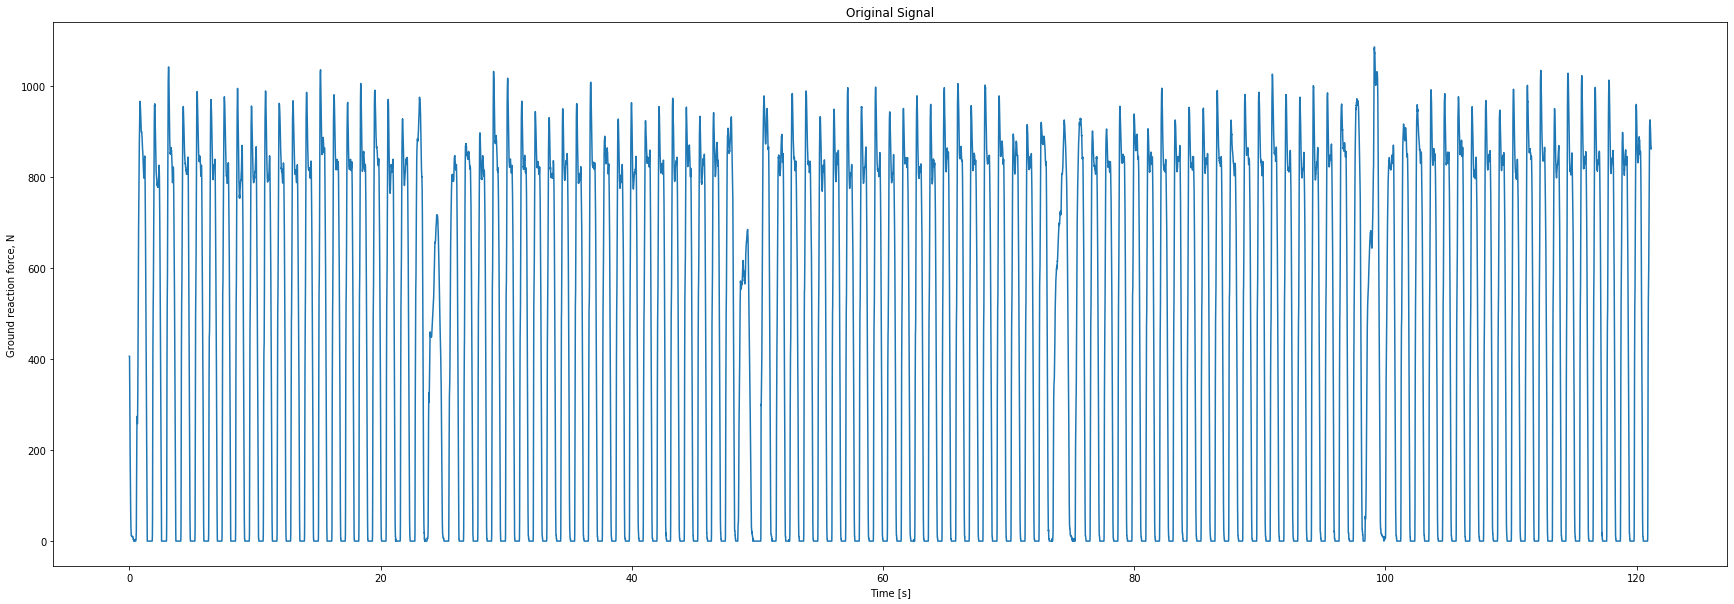

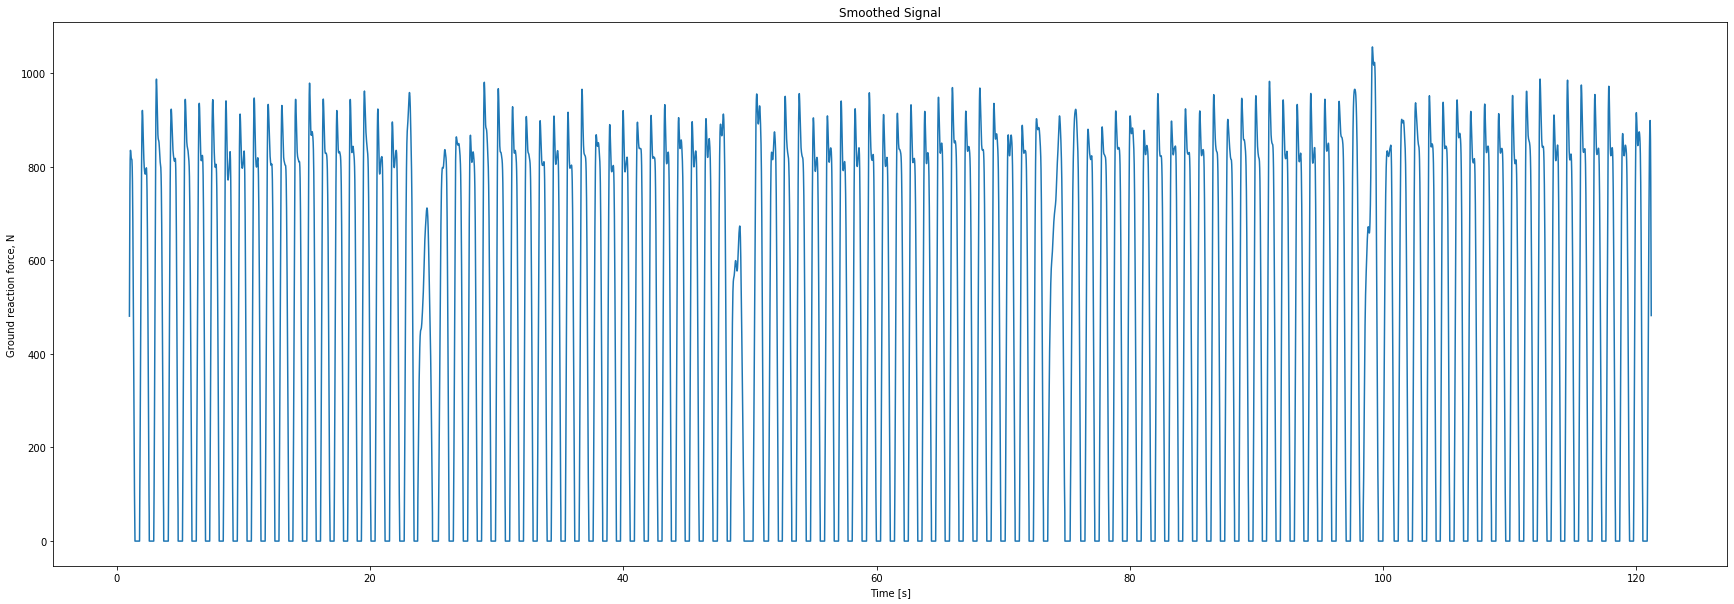

No handles with labels found to put in legend.


Abnormal abnormal steps are found - num: 24


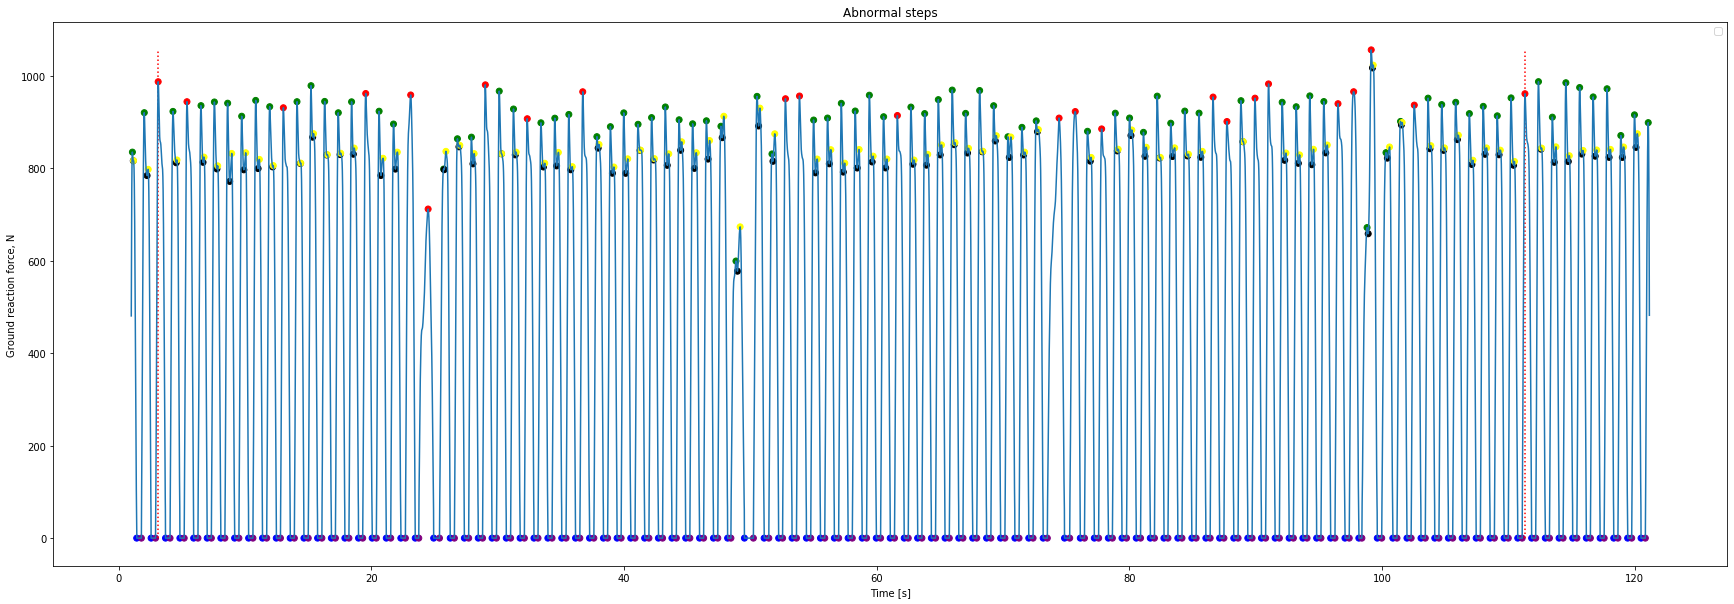

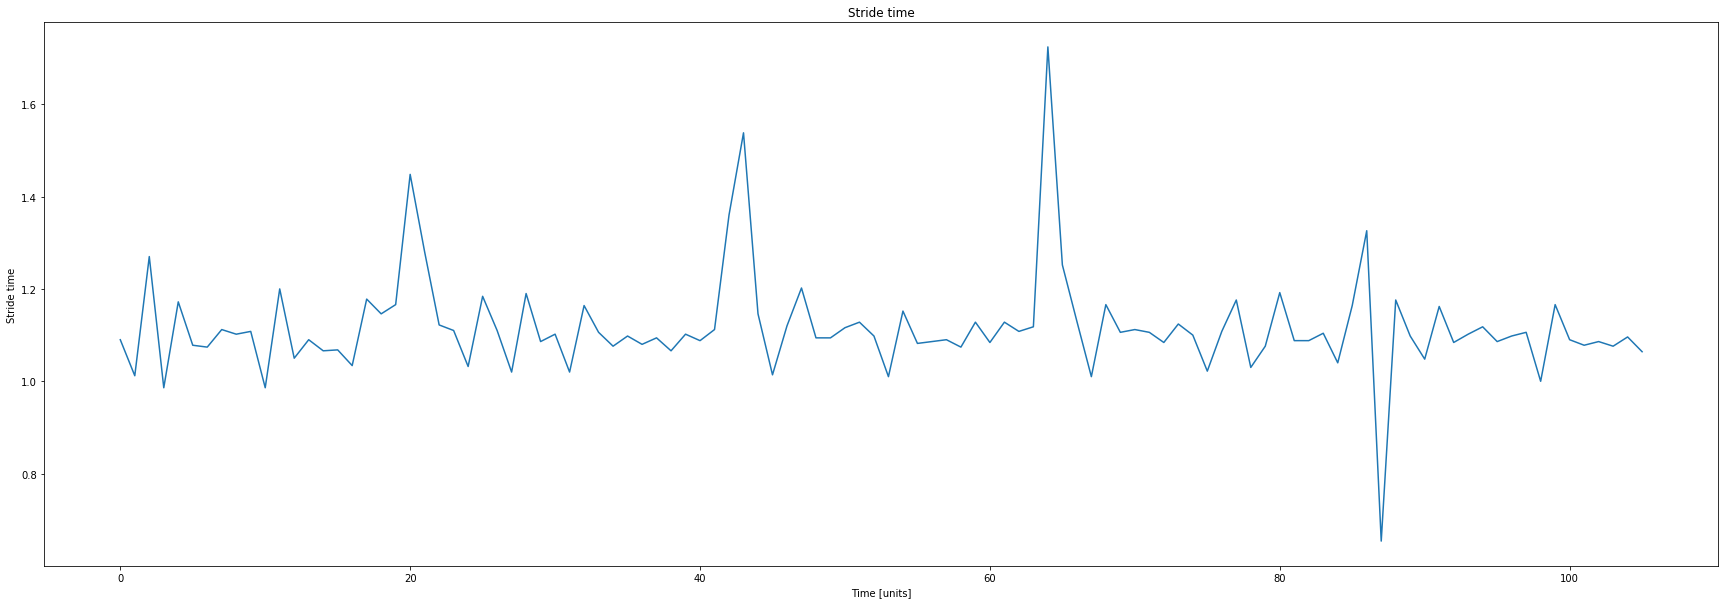

Stride time variance: 0.012274656353186194


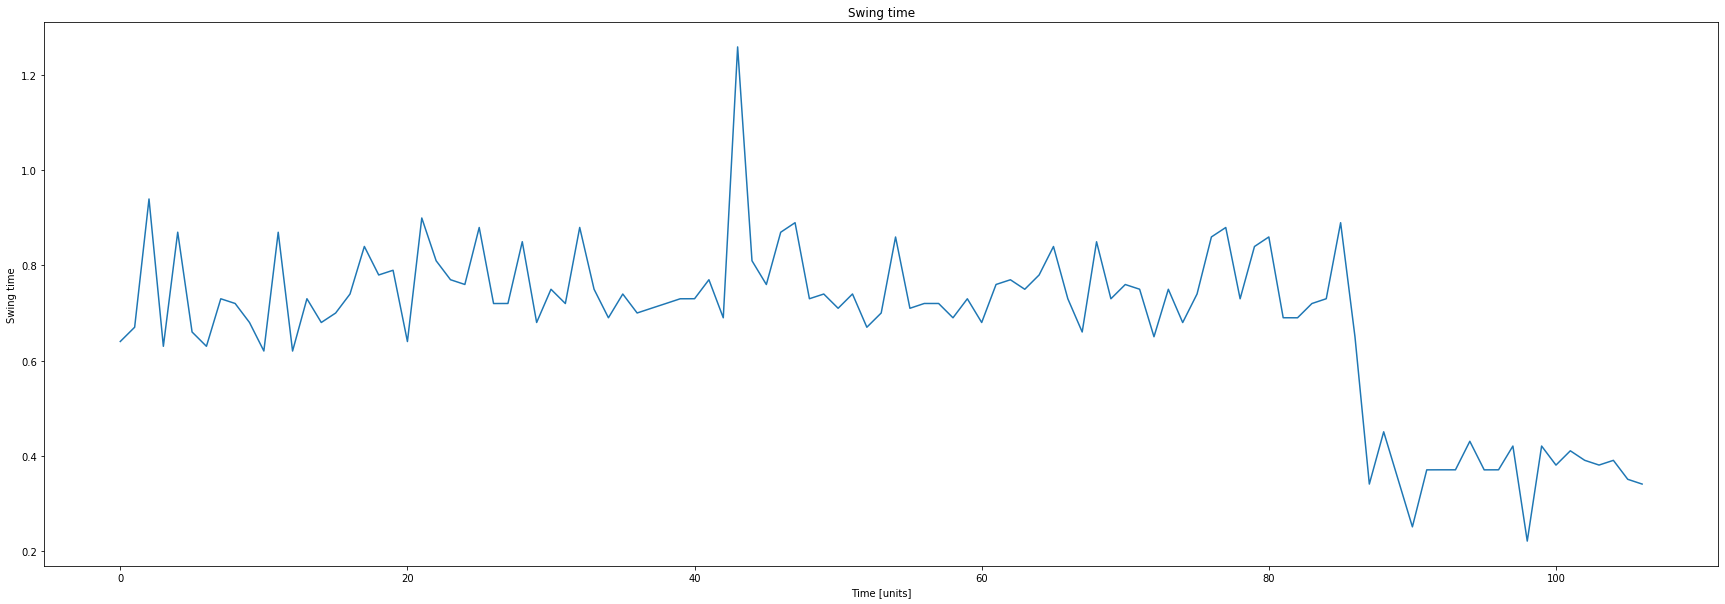

Swing time variance: 0.030058398506419698
Candence: 0.8830459307675486
Mid-swing/heel/strike force variance: 0.006088369174824152
Mid-swing/heel/strike time variance: 0.004496470850480079


IndexError: index 165 is out of bounds for axis 0 with size 165

In [185]:
pt = unique_pts[1]
curr = all_patients[all_patients.patient_id == pt]
x = curr.time
y = curr.total_force_R


demo = [curr.age[0], curr.gender[0], curr.speed[0], curr.height[0], curr.weight[0]]

print(curr.label[0])
if curr.label[0] == "control":
    tl = 0
else:
    tl = 1
print(curr.label[0], " - ", curr.patient_id[0])
matrix[c] = report(x, y, demo, tl, plot=True)

parkinson
parkinson  -  pt_21


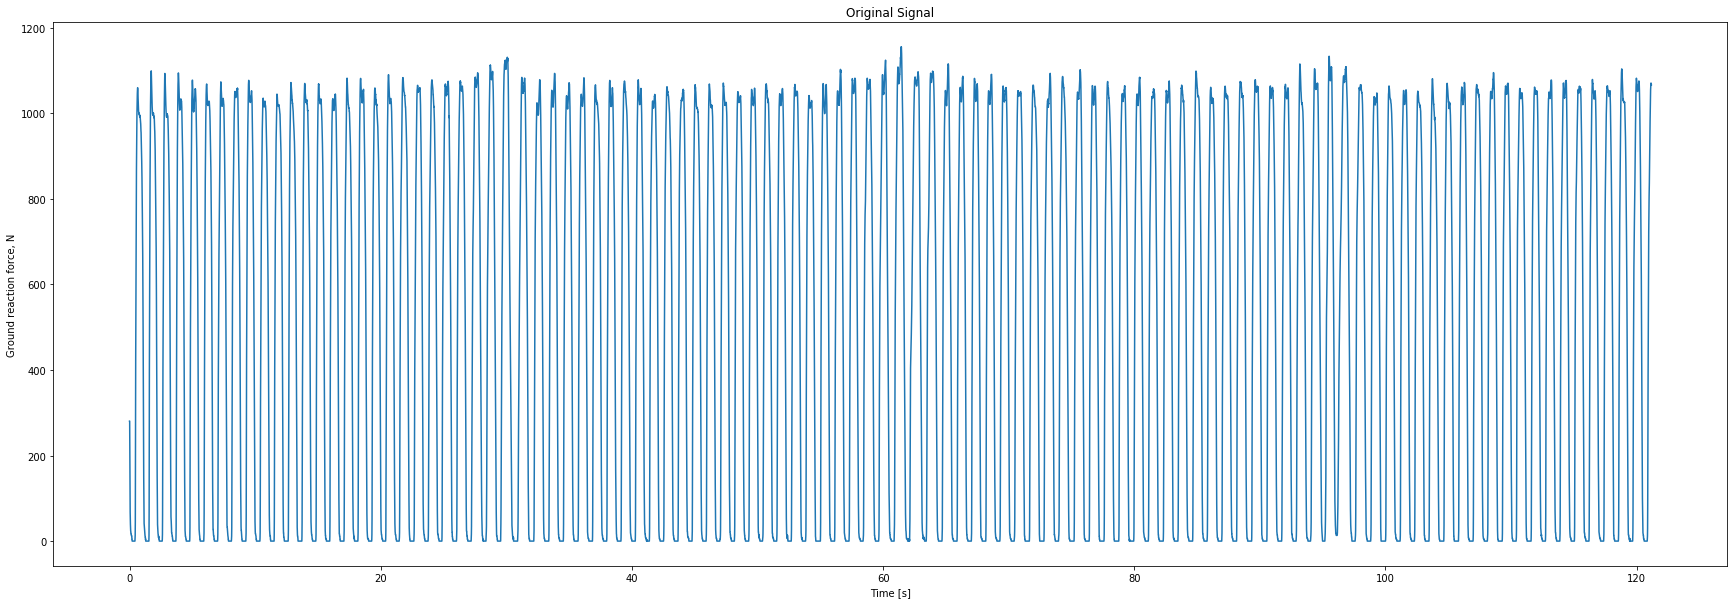

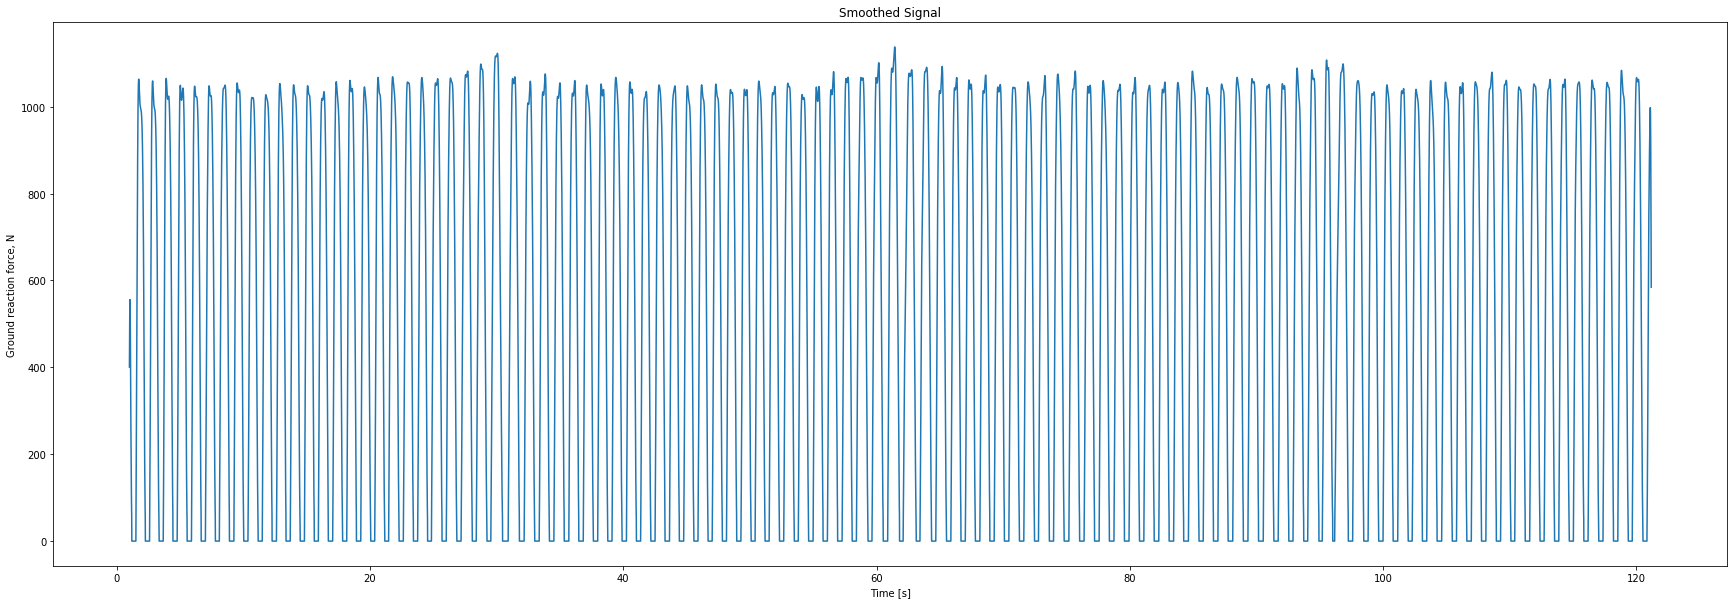

No handles with labels found to put in legend.


Abnormal abnormal steps are found - num: 45


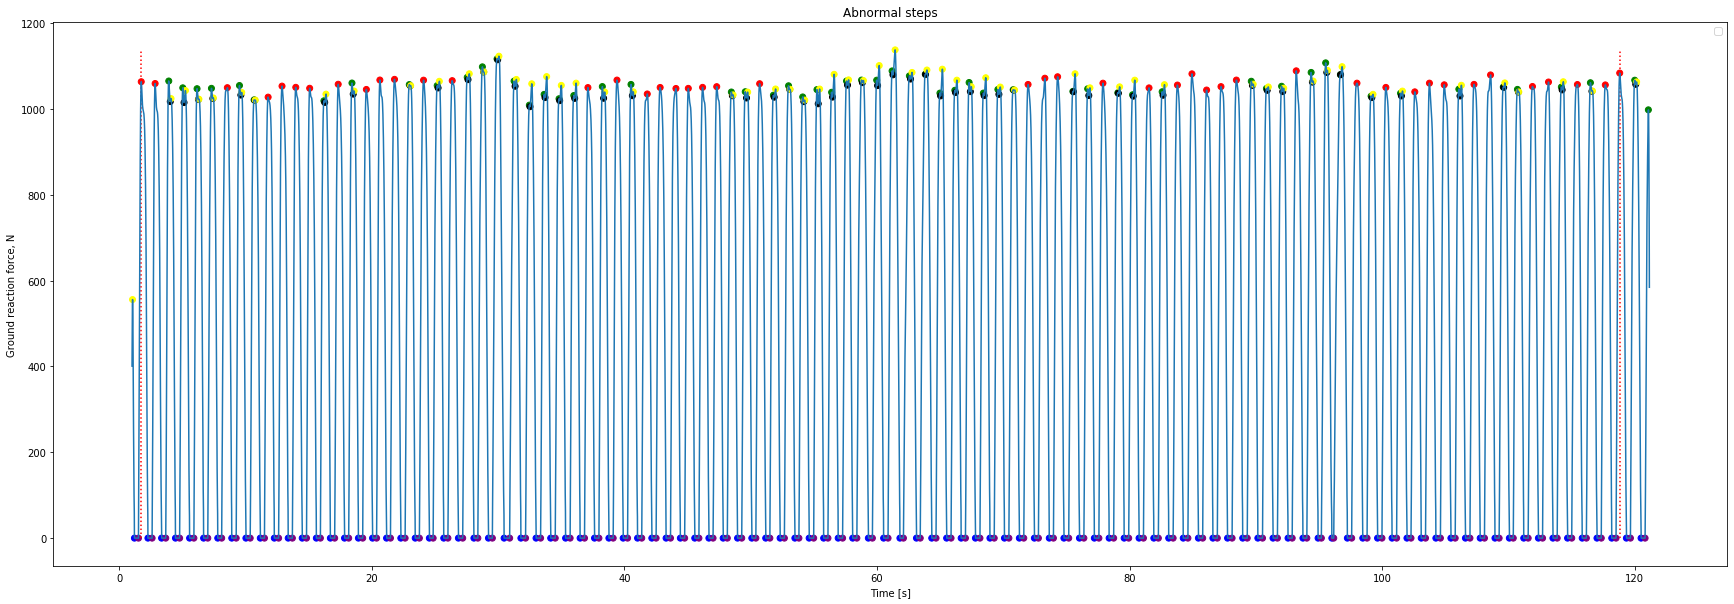

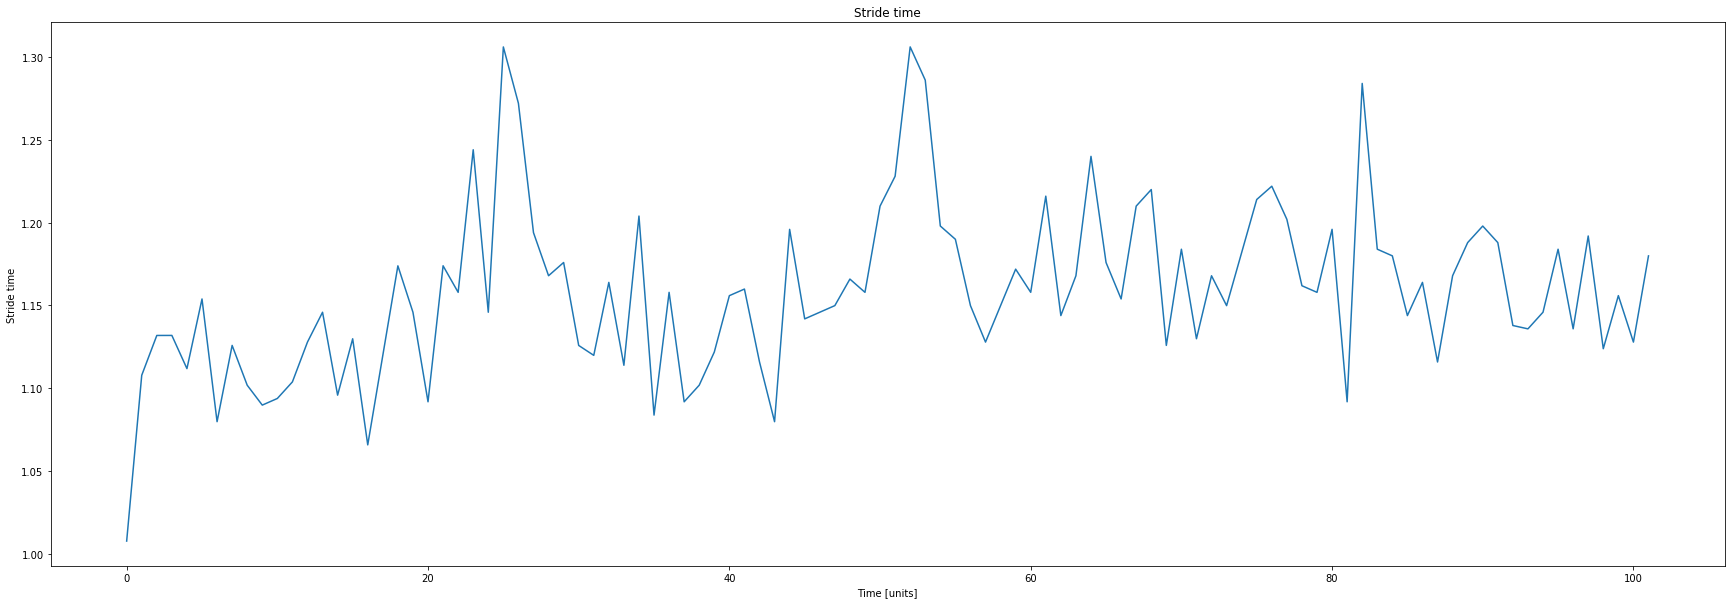

Stride time variance: 0.0025425892290657347


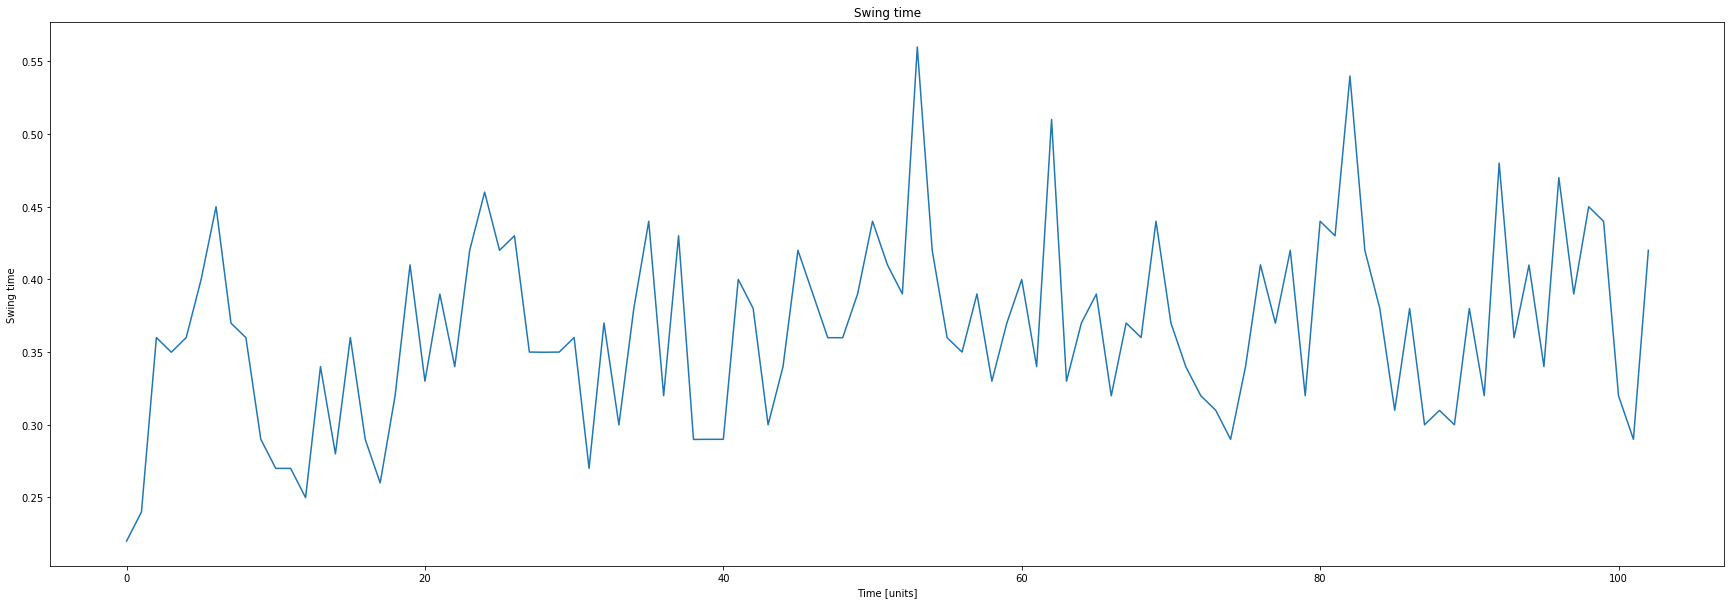

Swing time variance: 0.0038925893128476117
Candence: 0.8582876336432247
Mid-swing/heel/strike force variance: 0.00036513984717220376
Mid-swing/heel/strike time variance: 0.2634319529467902


array([1.15833059e+00, 8.58287634e-01, 4.32692308e-01, 2.25605971e-01,
       1.04945447e+03, 5.23498366e+02, 1.95344736e+05, 7.20000000e+01,
       0.00000000e+00, 8.48000000e-01, 1.70000000e+00, 8.20000000e+01,
       1.00000000e+00])

In [190]:
pt = unique_pts[21]
curr = all_patients[all_patients.patient_id == pt]
x = curr.time
y = curr.total_force_R


demo = [curr.age[0], curr.gender[0], curr.speed[0], curr.height[0], curr.weight[0]]

print(curr.label[0])
if curr.label[0] == "control":
    tl = 0
else:
    tl = 1
print(curr.label[0], " - ", curr.patient_id[0])
report(x, y, demo, tl, plot=True)

Get records for all population

In [121]:
matrix = np.zeros((len(unique_pts), 13))

c = 0
for pt in unique_pts:
    curr = all_patients[all_patients.patient_id == pt]
    x = curr.time
    y = curr.total_force_R
    
    
    demo = [curr.age[0], curr.gender[0], curr.speed[0], curr.height[0], curr.weight[0]]
    
    print(curr.label[0])
    if curr.label[0] == "control":
        tl = 0
    else:
        tl = 1
    print(curr.label[0], " - ", curr.patient_id[0])
    matrix[c] = report(x, y, demo, tl, plot=False)
    c+= 1
    print("\n")


control
control  -  pt_0
Abnormal abnormal steps are found - num: 7
Stride time variance: 0.0038811021437500023
Swing time variance: 0.005238269021150002
Candence: 0.8005182736864692
Mid-swing/heel/strike force variance: 0.008338816036060022
Mid-swing/heel/strike time variance: 0.0027319333163265424


control
control  -  pt_1
Abnormal abnormal steps are found - num: 24
Stride time variance: 0.012274656353186194
Swing time variance: 0.030058398506419698
Candence: 0.8830459307675486
Mid-swing/heel/strike force variance: 0.006088369174824152
Mid-swing/heel/strike time variance: 0.004496470850480079


control
control  -  pt_2
Abnormal abnormal steps are found - num: 20
Stride time variance: 0.053449285647849794
Swing time variance: 0.059547260077854776
Candence: 0.7840127422702533
Mid-swing/heel/strike force variance: 0.0020693498239764125
Mid-swing/heel/strike time variance: 0.003032229105294157


control
control  -  pt_3
Abnormal abnormal steps are found - num: 4
Stride time variance: 0.

Stride time variance: 0.006261891272805157
Swing time variance: 0.05068930767024795
Candence: 0.8995514621837644
Mid-swing/heel/strike force variance: 0.04772188383260476
Mid-swing/heel/strike time variance: 0.016812994453719022


parkinson
parkinson  -  pt_29
Abnormal abnormal steps are found - num: 1
Stride time variance: 0.008478131169719006
Swing time variance: 0.02060991722912097
Candence: 0.9160569935999803
Mid-swing/heel/strike force variance: 0.015756297710824634
Mid-swing/heel/strike time variance: 0.0016260624090983049


parkinson
parkinson  -  pt_30
Abnormal abnormal steps are found - num: 65
Stride time variance: 0.003659508116537593
Swing time variance: 0.0049224349529026715
Candence: 0.8500348679351168
Mid-swing/heel/strike force variance: 0.0006047130063106587
Mid-swing/heel/strike time variance: 0.29443207918108427


parkinson
parkinson  -  pt_31
Abnormal abnormal steps are found - num: 89
Stride time variance: 0.002261316186332344
Swing time variance: 0.004113624022744

control
control  -  pt_56
No abnormal steps are found
Stride time variance: 0.005024757360255223
Swing time variance: 0.0023520683126368827
Candence: 0.8192755611207246
Mid-swing/heel/strike force variance: 0.037556296003033694
Mid-swing/heel/strike time variance: 0.0009829960336011528


control
control  -  pt_57
Abnormal abnormal steps are found - num: 2
Stride time variance: 0.009181804050380613
Swing time variance: 0.005990424348296331
Candence: 0.8921781908078674
Mid-swing/heel/strike force variance: 0.013677655929545104
Mid-swing/heel/strike time variance: 0.0014887136651568391


control
control  -  pt_58
Abnormal abnormal steps are found - num: 13
Stride time variance: 0.002615433036756927
Swing time variance: 0.003158283743749997
Candence: 0.8878658701030036
Mid-swing/heel/strike force variance: 0.00076044574776689
Mid-swing/heel/strike time variance: 0.0020827646484375133


control
control  -  pt_59
Abnormal abnormal steps are found - num: 123
Stride time variance: 0.0302514625

Abnormal abnormal steps are found - num: 84
Stride time variance: 0.007900942618717563
Swing time variance: 0.004304655986531189
Candence: 0.9537037694634198
Mid-swing/heel/strike force variance: 0.004080059937846415
Mid-swing/heel/strike time variance: 0.1067886898298677


parkinson
parkinson  -  pt_84
Abnormal abnormal steps are found - num: 123
Stride time variance: 0.008224192478320777
Swing time variance: 0.010955628504888763
Candence: 0.9159829871426521
Mid-swing/heel/strike force variance: 0.0018425679953713266
Mid-swing/heel/strike time variance: 0.2701147132812224


parkinson
parkinson  -  pt_85
No abnormal steps are found
Stride time variance: 0.007215229972175214
Swing time variance: 0.0069838733333335
Candence: 0.7601884253710353
Mid-swing/heel/strike force variance: 0.008948132221405437
Mid-swing/heel/strike time variance: 0.0018160966666667018


parkinson
parkinson  -  pt_86
Abnormal abnormal steps are found - num: 89
Stride time variance: 0.0034765854838246994
Swing time

Stride time variance: 0.0012527770891653089
Swing time variance: 0.00491879309408281
Candence: 1.0811123077621387
Mid-swing/heel/strike force variance: 0.02901696421117751
Mid-swing/heel/strike time variance: 0.004836062994674529


control
control  -  pt_112
Abnormal abnormal steps are found - num: 1
Stride time variance: 0.0010638672045599473
Swing time variance: 0.0004995218654554201
Candence: 0.940815290724304
Mid-swing/heel/strike force variance: 0.06283269415220702
Mid-swing/heel/strike time variance: 0.0006523200031325968


control
control  -  pt_113
Abnormal abnormal steps are found - num: 10
Stride time variance: 0.0023462901197850742
Swing time variance: 0.0033775366383135916
Candence: 0.8665403993513326
Mid-swing/heel/strike force variance: 0.008459490058955901
Mid-swing/heel/strike time variance: 0.003904935787490756


control
control  -  pt_114
Abnormal abnormal steps are found - num: 2
Stride time variance: 0.00206463602957784
Swing time variance: 0.0035941412886259265
Can

Swing time variance: 0.008922926959010142
Candence: 0.8912986964756564
Mid-swing/heel/strike force variance: 0.043360494833994345
Mid-swing/heel/strike time variance: 0.006387699910781867


parkinson
parkinson  -  pt_140
Abnormal abnormal steps are found - num: 5
Stride time variance: 0.0048679660249041105
Swing time variance: 0.004228897852416227
Candence: 0.940815290724304
Mid-swing/heel/strike force variance: 0.02761667002516595
Mid-swing/heel/strike time variance: 0.0014257765302785352


parkinson
parkinson  -  pt_141
Abnormal abnormal steps are found - num: 13
Stride time variance: 0.00787875047280307
Swing time variance: 0.02785490989899997
Candence: 0.825276570810793
Mid-swing/heel/strike force variance: 0.009705733082371023
Mid-swing/heel/strike time variance: 0.0058409229918635055


parkinson
parkinson  -  pt_142
Abnormal abnormal steps are found - num: 2
Stride time variance: 0.0009635452258271431
Swing time variance: 0.0018657500730400246
Candence: 0.8665403993513326
Mid-swi

XGBoost

In [122]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [126]:
X = matrix[:, :12]
Y = matrix[:, 12]

In [176]:
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size)

In [177]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [178]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [179]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 80.00%


In [180]:
from sklearn.metrics import precision_score
precision_score(y_test, predictions)

0.8235294117647058

In [181]:
from sklearn.metrics import f1_score
f1_score(y_test, predictions)

0.8358208955223881

In [182]:
from sklearn.metrics import recall_score
recall_score(y_test, predictions)

0.8484848484848485

T - test

If we observe a large p-value, for example larger than 0.05 or 0.1, then we cannot reject the null hypothesis of identical average scores (this means the averages are the same). 
If the p-value is smaller than the threshold, e.g. 1%, 5% or 10%, then we reject the null hypothesis of equal averages (this means the averages are significantly different)



A large t-score tells you that the groups are different.\
A small t-score tells you that the groups are similar.

Low p-values are good

In [28]:
from scipy.stats import ttest_ind

In [116]:
indx_p = np.where(matrix[:, 18] == 1)
indx_c = np.where(matrix[:, 18] == 0)
parkinson = matrix[indx_p]
control = matrix[indx_c]

In [117]:
features = ["Mean", "var", "mean stride time", "var stride time", \
               "mean swing time", "var swing time", "cadence /per second", 
               "abnormal %", "var mid-swing heel-strike time", \
                "var mid-swing heel-strike value", \
            
            "midswing1_val_mean", "midswing1_val_var", \
            "midswing2_val_mean", "midswing2_val_var",\
            "heel_strike_val_mean", "heel_strike_val_var", "CV swing", "CV stride"\
            ]
for i in range(0, matrix.shape[1]-1):
    print(features[i], end = " ")
    test = ttest_ind(control[:,i], parkinson[:,i] ) 
    print("{:.2f} {:.2f}".format(np.mean(control[:,i]), np.mean(parkinson[:,i])), end = " ")
    print("{:.2f} {:.2f}".format(test[0], test[1]))
    

Mean 444.28 451.80 -0.71 0.48
var 146593.07 142340.28 0.62 0.54
mean stride time 1.08 1.12 -2.14 0.03
var stride time 0.01 0.01 -0.05 0.96
mean swing time 0.45 0.44 0.76 0.45
var swing time 0.02 0.01 0.97 0.34
cadence /per second 0.93 0.89 2.11 0.04
abnormal % 0.20 0.32 -2.35 0.02
var mid-swing heel-strike time 0.03 0.04 -1.62 0.11
var mid-swing heel-strike value 0.07 0.09 -0.47 0.64
midswing1_val_mean 966.89 941.08 0.93 0.35
midswing1_val_var 3068.11 3070.75 -0.00 1.00
midswing2_val_mean 905.91 918.42 -0.58 0.56
midswing2_val_var 5713.53 6218.49 -0.29 0.77
heel_strike_val_mean 774.11 822.95 -1.86 0.06
heel_strike_val_var 8281.48 6796.61 0.64 0.52
CV swing 24336.98 14202.57 1.95 0.05
CV stride 46844.64 31471.84 2.46 0.02
